In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomBrightness
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

100%|██████████| 675M/675M [00:06<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


In [3]:
train = image_dataset_from_directory(
    directory = f'{path}/cell_images/cell_images',
    image_size = (180, 180),
    batch_size = 32,
    label_mode = 'binary',
    shuffle = True,
    validation_split = 0.3,
    subset = 'training',
    seed = 42
)

val_test = image_dataset_from_directory(
    directory = f'{path}/cell_images/cell_images',
    image_size = (180, 180),
    batch_size = 32,
    label_mode = 'binary',
    shuffle = True,
    validation_split = 0.3,
    subset = 'validation',
    seed = 42
)

val = val_test.take(int(len(val_test) * 0.7))
test = val_test.skip(int(len(val_test) * 0.7))

class_names = train.class_names
print(f'Classes name in the dataset : {class_names}')
print(f'Train batches : {len(train)}')
print(f'Validation batches : {len(val)}')
print(f'Test batches : {len(test)}')

Found 27558 files belonging to 2 classes.
Using 19291 files for training.
Found 27558 files belonging to 2 classes.
Using 8267 files for validation.
Classes name in the dataset : ['Parasitized', 'Uninfected']
Train batches : 603
Validation batches : 181
Test batches : 78


In [4]:
batch = train.as_numpy_iterator().next()
print(f"Min pixel value : {batch[0].min()}")
print(f"Max pixel value : {batch[0].max()}")

Min pixel value : 0.0
Max pixel value : 249.70834350585938


Dimensions of an image : (180, 180, 3)


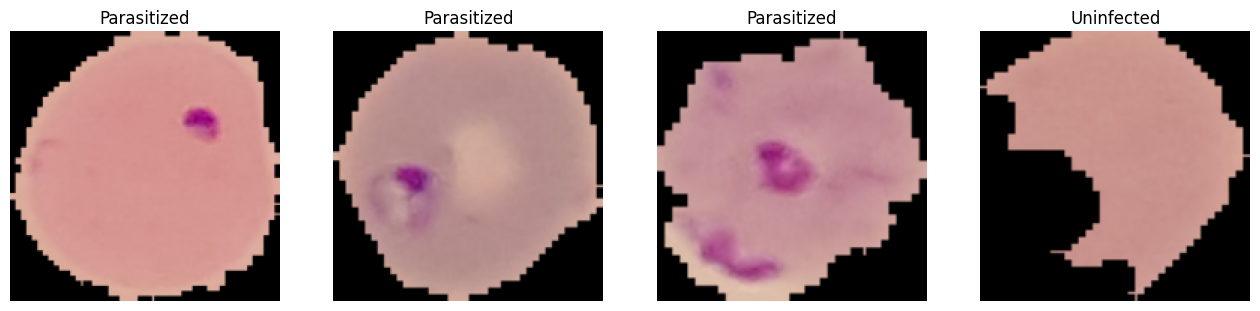

In [6]:
batch = train.as_numpy_iterator().next()
fig, axes = plt.subplots(ncols = 4, figsize = (16, 4))
for index, image in enumerate(batch[0][:4]) :
    axes[index].imshow(image.astype(np.uint8))
    class_name = class_names[int(batch[1][index])]
    axes[index].set_title(class_name)
    axes[index].set_axis_off()
print(f"Dimensions of an image : {batch[0][0].shape}")

In [7]:
train = train.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
val = val.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
test = test.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomTranslation(0.2, 0.2),
    # RandomBrightness(0.2)
])

train = train.map(lambda x, y: (data_augmentation(x, training = True), y))

In [8]:
batch = train.as_numpy_iterator().next()
print(f"Min pixel value : {batch[0].min()}")
print(f"Max pixel value : {batch[0].max()}")

Min pixel value : 0.0
Max pixel value : 0.9112059473991394


Dimensions of an image : (180, 180, 3)


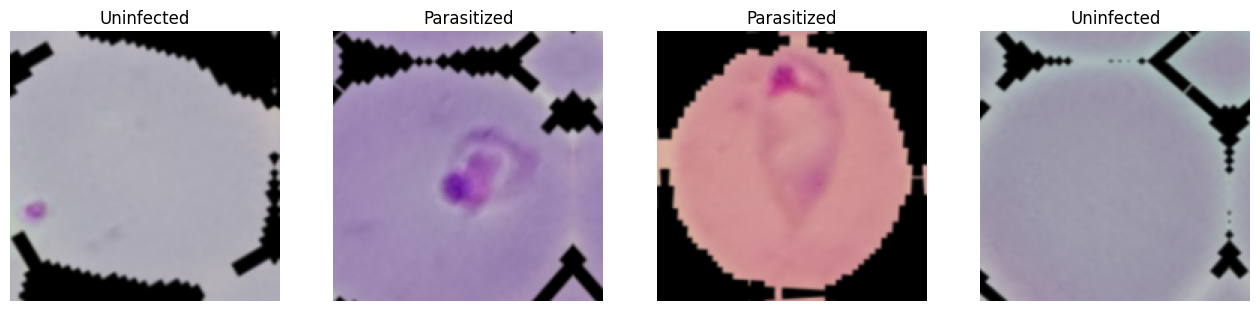

In [12]:
batch = train.as_numpy_iterator().next()
fig, axes = plt.subplots(ncols = 4, figsize = (16, 4))
for index, image in enumerate(batch[0][:4]) :
    axes[index].imshow(image)
    class_name = class_names[int(batch[1][index])]
    axes[index].set_title(class_name)
    axes[index].set_axis_off()
print(f"Dimensions of an image : {batch[0][0].shape}")

In [13]:
model = Sequential([
    Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, activation = 'relu', padding = 'same', input_shape = (180, 180, 3), name = 'first_layer'),
    MaxPooling2D(pool_size = (2, 2), name = 'first_pooling'),
    Dropout(rate = 0.25, name = 'first_dropout'),

    Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, activation = 'relu', padding = 'same', name = 'second_layer'),
    MaxPooling2D(pool_size = (2, 2), name = 'second_pooling'),
    Dropout(rate = 0.25, name = 'second_dropout'),

    Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, activation = 'relu', padding = 'same', name = 'third_layer'),
    MaxPooling2D(pool_size = (2, 2), name = 'third_pooling'),
    Dropout(rate = 0.25, name = 'third_dropout'),

    Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, activation = 'relu', padding = 'same', name = 'fourth_layer'),
    MaxPooling2D(pool_size = (2, 2), name = 'fourth_pooling'),
    Dropout(rate = 0.25, name = 'fourth_dropout'),

    Flatten(name = 'flatten'),
    Dense(units = 256, activation = 'relu', name = 'dense'),
    Dropout(rate = 0.5, name = 'final_dropout'),
    Dense(units = 1, activation = 'sigmoid', name = 'output')
], name = 'Paludisme_CNN_Model')

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "Paludisme_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ first_layer (Conv2D)                 │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_pooling (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_dropout (Dropout)              │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_layer (Conv2D)                │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_pooling (MaxPooling2D)        │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_dropout (Dropout)             │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_layer (Conv2D)                 │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_pooling (MaxPooling2D)         │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_dropout (Dropout)              │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fourth_layer (Conv2D)                │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fourth_pooling (MaxPooling2D)        │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fourth_dropout (Dropout)             │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       7,930,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ final_dropout (Dropout)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,318,785 (31.73 MB)

 Trainable params: 8,318,785 (31.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(patience = 10, monitor = 'val_loss', restore_best_weights = True)
model_checkpoint = ModelCheckpoint(filepath = 'best_prediction_model_for_paludisme.keras', save_best_only = True)

In [ ]:
history = model.fit(train, validation_data = val, callbacks = [early_stopping, model_checkpoint], epochs = 200)

Epoch 1/200
603/603 ━━━━━━━━━━━━━━━━━━━━ 250s 397ms/step - accuracy: 0.5782 - loss: 0.6843 - val_accuracy: 0.9406 - val_loss: 0.2237
Epoch 2/200
603/603 ━━━━━━━━━━━━━━━━━━━━ 228s 377ms/step - accuracy: 0.9128 - loss: 0.2543 - val_accuracy: 0.9548 - val_loss: 0.1719
Epoch 3/200
603/603 ━━━━━━━━━━━━━━━━━━━━ 260s 374ms/step - accuracy: 0.9222 - loss: 0.2249 - val_accuracy: 0.9489 - val_loss: 0.1591
Epoch 4/200
603/603 ━━━━━━━━━━━━━━━━━━━━ 225s 373ms/step - accuracy: 0.9258 - loss: 0.2236 - val_accuracy: 0.9541 - val_loss: 0.1496
Epoch 5/200
603/603 ━━━━━━━━━━━━━━━━━━━━ 263s 374ms/step - accuracy: 0.9281 - loss: 0.2150 - val_accuracy: 0.9553 - val_loss: 0.1458
Epoch 6/200
603/603 ━━━━━━━━━━━━━━━━━━━━ 262s 373ms/step - accuracy: 0.9302 - loss: 0.2096 - val_accuracy: 0.9537 - val_loss: 0.1555
Epoch 7/200
603/603 ━━━━━━━━━━━━━━━━━━━━ 223s 370ms/step - accuracy: 0.9339 - loss: 0.2038 - val_accuracy: 0.9544 - val_loss: 0.1485
Epoch 8/200
603/603 ━━━━━━━━━━━━━━━━━━━━ 262s 370ms/step - accuracy: 

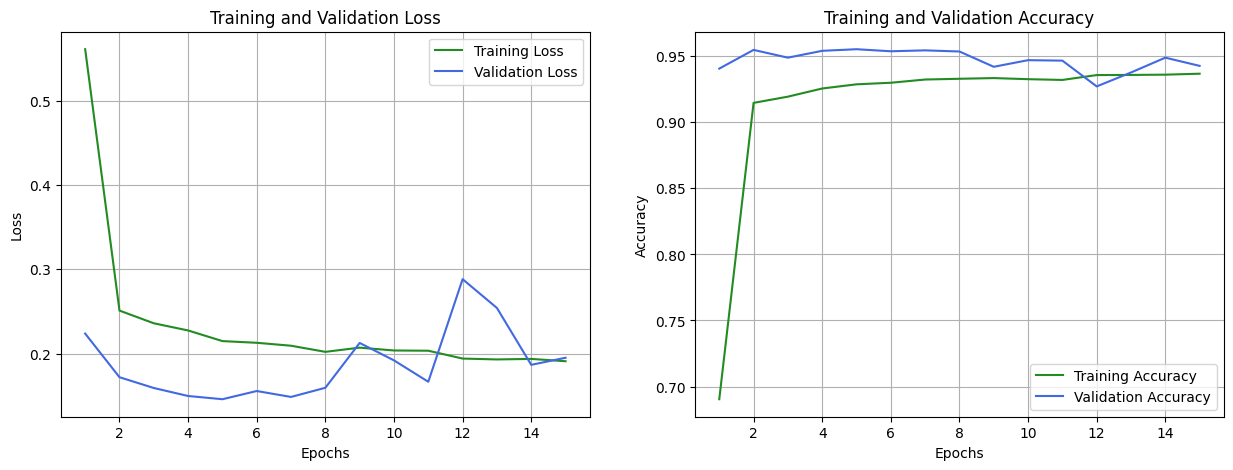

In [16]:
fig, ax = plt.subplots(ncols = 2, figsize = (15, 5))
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

ax[0].plot(epochs, train_loss, color = 'forestgreen', label = 'Training Loss')
ax[0].plot(epochs, val_loss, color = 'royalblue', label = 'Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(epochs, train_acc, color = 'forestgreen', label = 'Training Accuracy')
ax[1].plot(epochs, val_acc, color = 'royalblue', label = 'Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.show()

In [17]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

y_true = []
y_preds = []

for batch in test.as_numpy_iterator() :
    X, y = batch
    y_pred = model.predict(X, verbose = 0)
    y_true.extend(y)
    y_preds.extend(y_pred)

    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

y_true = np.array(y_true)
y_preds = np.array(y_preds)

print(f'Precision : {precision.result().numpy():.2f}')
print(f'Recall : {recall.result().numpy():.2f}')
print(f'Accuracy : {accuracy.result().numpy():.2f}')

Precision : 0.94
Recall : 0.98
Accuracy : 0.96


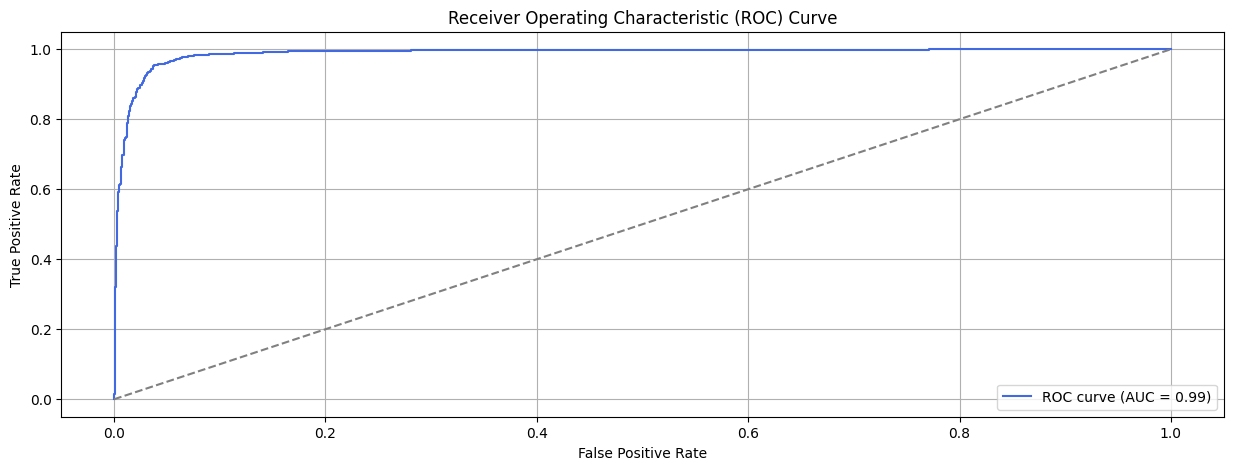

In [18]:
fpr, tpr, thresholds = roc_curve(y_true, y_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (15, 5))
plt.plot(fpr, tpr, color = 'royalblue', label = f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color = 'gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = "lower right")
plt.grid()
plt.show()